In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("/global/homes/a/arosado/")
from prepare_data import prepare_LRGmock_data, maps_dr9, hpixsum
from astropy.table import Table, vstack

import os
import utils as ut
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [14]:
maps_dr9

['EBV',
 'STARDENS',
 'galdepth_rmag_ebv',
 'galdepth_gmag_ebv',
 'galdepth_zmag_ebv',
 'psfdepth_rmag_ebv',
 'psfdepth_gmag_ebv',
 'psfdepth_zmag_ebv',
 'psfdepth_w1mag_ebv',
 'psfdepth_w2mag_ebv',
 'PSFSIZE_R',
 'PSFSIZE_G',
 'PSFSIZE_Z']

In [15]:
for i in range(len(maps_dr9)):
    if i==0 or i==4 or i==10:
        print(maps_dr9[i])

EBV
galdepth_zmag_ebv
PSFSIZE_R


In [ ]:
%%time
norm_method = 'mean'
mock_main = ut.get_mock(contaminated=False, selection_fn=None, nside=256, norm_method=norm_method,
                        tracer='LRG', ph=0, main=1, nz=0, Y5=1, sv3=0)
mock_raw = ut.get_mock(contaminated=False, selection_fn=None, nside=256, norm_method=norm_method,
                       tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)

In [ ]:
dndz_main = Table()
dndz_raw = Table()
bins = 1000

n_raw, z_raw = np.histogram(mock_raw['Z'], bins=bins)
bc_raw = (z_raw[:-1] + z_raw[1:])/2.
dndz_raw.add_column(bc_raw, name='zmid')
dndz_raw.add_column(n_raw, name='n(z)')

n_main, z_main = np.histogram(mock_main['Z'], bins=bins)
bc_main = (z_main[:-1] + z_main[1:])/2.
dndz_main.add_column(bc_main, name='zmid')
dndz_main.add_column(n_main, name='n(z)')

plt.plot(dndz_raw['zmid'], dndz_raw['n(z)'], label='dndz: main=0,Y5=1')
plt.plot(dndz_main['zmid'], dndz_main['n(z)'], label='dndz: main=1,Y5=1')
plt.legend()
plt.show()

In [5]:
dndz_main.write('LRG_nz_main.fits', format='fits')
dndz_raw.write('LRG_nz_raw.fits', format='fits')

In [6]:
# read files
raw = Table.read('LRG_nz_raw.fits')
main = Table.read('LRG_nz_main.fits')

In [9]:
f_main = interpolate.interp1d(main['zmid'], main['n(z)'], fill_value='extrapolate')
f_raw = interpolate.interp1d(raw['zmid'], raw['n(z)'], fill_value='extrapolate')

In [10]:
n_main = f_main(mock_main['Z'])
n_raw = f_raw(mock_raw['Z'])

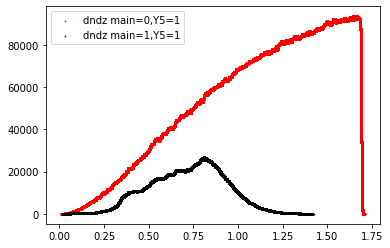

In [14]:
# do not rerun this cell, cell takes a lot of time to plot
plt.scatter(mock_raw['Z'], n_raw, 0.5, color='r', label='dndz main=0,Y5=1')
plt.scatter(mock_main['Z'], n_main, 0.5, color='k', label='dndz main=1,Y5=1')
plt.legend()
plt.show()

# Apply to mock contamination

In [3]:
nn_test1 = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits')

In [3]:
%%time
norm_method = 'mean'
downsampling = 'frac'
nside = 256

mock_main = ut.get_mock(contaminated=False, selection_fn=None, nside=nside, norm_method=norm_method, downsampling='mean',
                        tracer='LRG', ph=0, main=1, nz=0, Y5=1, sv3=0)
mock_raw = ut.get_mock(contaminated=False, selection_fn=None, nside=nside, norm_method=norm_method, downsampling='mean',
                       tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)
mock_cont_frac = ut.get_mock(contaminated=True, selection_fn=nn_test1, nside=nside, norm_method=norm_method, downsampling=downsampling,
                             tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)
mock_cont = ut.get_mock(contaminated=True, selection_fn=nn_test1, nside=nside, norm_method=norm_method, downsampling='mean',
                        tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)

using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=1, nz=0, Y5=1, sv3=0
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
contaminating mock
contamination using mean
using frac when downsampling
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
contaminating mock
contamination using mean
CPU times: user 47.3 s, sys: 27.3 s, total: 1min 14s
Wall time: 1min 15s


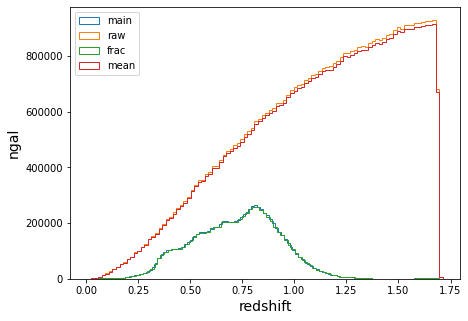

In [4]:
kw = dict(histtype='step', bins=100)
font = 14
fig = plt.gcf()
fig.set_size_inches(7, 5)

plt.hist(mock_main['Z'], label='main', **kw)
plt.hist(mock_raw['Z'], label='raw', **kw)
plt.hist(mock_cont_frac['Z'], label='frac', **kw)
plt.hist(mock_cont['Z'], label='mean', **kw)

plt.legend(loc='upper left')
plt.ylabel('ngal', fontsize=font)
plt.xlabel('redshift', fontsize=font)
fn = os.path.join(f'hist_frac.png')
#plt.savefig(fn, facecolor='white',bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

In [4]:
%%time
norm_method = 'mean'
downsampling = 'frac'
nside = 256

mock_main = ut.get_mock(contaminated=False, selection_fn=None, nside=nside, norm_method=norm_method, downsampling='mean',
                        tracer='LRG', ph=0, main=1, nz=0, Y5=1, sv3=0)

mock_raw = ut.get_mock(contaminated=False, selection_fn=None, nside=nside, norm_method=norm_method, downsampling='mean',
                       tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)

mock_sh_frac = ut.get_mock(contaminated=True, selection_fn=nn_test1, nside=nside, norm_method=norm_method, downsampling=downsampling,
                       do_shuffle=True, tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)

mock_uni_frac = ut.get_mock(contaminated=True, selection_fn=nn_test1, nside=nside, norm_method=norm_method, downsampling=downsampling,
                       ignore_prob=True, tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)

mock_cont_frac = ut.get_mock(contaminated=True, selection_fn=nn_test1, nside=nside, norm_method=norm_method, downsampling=downsampling,
                             tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)
#mock_cont = ut.get_mock(contaminated=True, selection_fn=nn_test1, nside=nside, norm_method=norm_method, downsampling='mean',
#                        tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)

using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=1, nz=0, Y5=1, sv3=0
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
contaminating mock
using mean for normalizing selection function
shuffling selection function
using frac when downsampling
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
contaminating mock
using mean for normalizing selection function
using frac when downsampling
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.

In [10]:
%%time
norm_method = 'mean'
downsampling = 'frac'
nside = 256

mock_main = ut.get_mock(contaminated=False, selection_fn=None, nside=nside, norm_method=norm_method, downsampling='mean',
                        tracer='LRG', ph=0, main=1, nz=0, Y5=1, sv3=0)

using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=1, nz=0, Y5=1, sv3=0
CPU times: user 2.49 s, sys: 4.11 s, total: 6.61 s
Wall time: 6.73 s


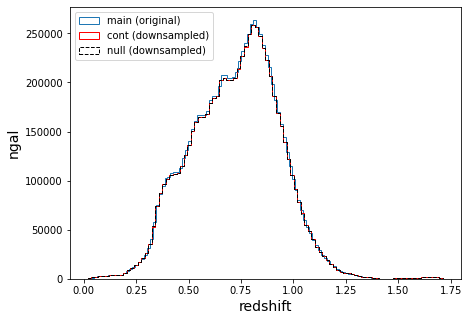

In [12]:
kw = dict(histtype='step', bins=100)
font = 14
fig = plt.gcf()
fig.set_size_inches(7, 5)

#plt.hist(mock_main['Z'], label='main', lw=4, alpha=0.5, **kw)
#plt.hist(mock_raw['Z'], label='raw', **kw)
#plt.hist(mock_uni_frac['Z'], label='uni frac', **kw)
plt.hist(mock_main['Z'], label='main (original)', **kw)
plt.hist(mock_cont_frac['Z'], label='cont (downsampled)', color='r', **kw)
plt.hist(mock_sh_frac['Z'], ls='--', label='null (downsampled)', color='k', **kw)

plt.legend(loc='upper left')
plt.ylabel('ngal', fontsize=font)
plt.xlabel('redshift', fontsize=font)
fn = os.path.join(f'hist_frac_compare3.png')
plt.savefig(fn, facecolor='white',bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

In [5]:
import numpy as np
seed = 24
np.random.seed(seed=seed)
np.random.uniform(size=10)

array([0.9600173 , 0.69951205, 0.99986729, 0.2200673 , 0.36105635,
       0.73984099, 0.99645573, 0.31634698, 0.13654458, 0.38398001])

In [6]:
np.random.seed(seed=seed*2)
np.random.uniform(size=10)

array([0.01749027, 0.89157327, 0.28486117, 0.29897638, 0.79203426,
       0.3244706 , 0.86471039, 0.44751263, 0.54822991, 0.35717199])

In [7]:
np.random.seed(seed=seed)
np.random.uniform(size=10)

array([0.9600173 , 0.69951205, 0.99986729, 0.2200673 , 0.36105635,
       0.73984099, 0.99645573, 0.31634698, 0.13654458, 0.38398001])